In [40]:
from models import *
from impedance import preprocessing
from impedance.models.circuits import CustomCircuit
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [41]:
# def MakeCircuit(initial_guess,circuit):
#     CustomCircuit(initial_guess=[R1,R1*Q,R2*Q,delta,alpha],circuit=circuit)
    

In [42]:
R1=500
R2=100
Q=1e-6
alpha=0.98
delta1=0.3
R3=500
delta2=0.3
c1=CustomCircuit(initial_guess=[R1,R1*Q,R2*Q,delta1,alpha],circuit="TLMtwo")
f=np.logspace(-3,3,100)
zout=c1.predict(frequencies=f)


In [43]:
#ctwo=CustomCircuit(initial_guess=[R1, R1*Q, R2*Q, R3*Q, delta1, delta2, alpha],circuit="TLMtwo")
cthree=CustomCircuit(initial_guess=[R1, R1*Q, R2*Q, R3*Q, delta1, delta2, alpha],circuit="TLMthree")
clin=CustomCircuit(initial_guess=[R1, R1*Q, R2*Q, alpha],circuit="TLMlin")
cilin=CustomCircuit(initial_guess=[R1, R1*Q, R2*Q, alpha],circuit="TLMilin")

In [44]:
cthree.fit(impedance=zout,frequencies=f,bounds=[(0,0,0,0,0,0,0.5),(np.inf,np.inf,np.inf,np.inf,1,1,1)])
clin.fit(impedance=zout,frequencies=f,bounds=[(0,0,0,0.5),(np.inf,np.inf,np.inf,1)])


### Notes
Change the print function to directly print name of the parameters


In [45]:
# def profile_plotter(circuit,ax):
    
#     if(circuit._is_fit()):
#         param=circuit.parameters_
#     else:
#         param=circuit.initial_guess
#     profile=circuit.circuit

#     ax1=ax
#     if(profile=="TLMtwo"):
#        R1=param[0]
#        R1Q=param[1]
#        R2Q=param[2]
#        delta1=param[3]
#        Q=R1Q/R1
#        R2=R2Q/Q
#        ax1.plot([0,delta1,delta1,1],[R1,R1,R2,R2],linewidth=2,color="red",label="Actual")
    
#     if(profile=="TLMthree"):
#        R1=param[0]
#        R1Q=param[1]
#        R2Q=param[2]
#        R3Q=param[3]
#        delta1=param[4]
#        delta2=param[5]
#        Q=R1Q/R1
#        R2=R2Q/Q
#        R3=R3Q/Q
#        ax1.plot([0,delta1,delta1,delta2+delta1,delta2+delta1,1],[R1,R1,R2,R2,R3,R3],linewidth=2,color="blue",label="Actual")

#     if(profile=="TLMlin" or profile=="TLMlinzert"):
#        R1=param[0]
#        R1Q=param[1]
#        R2Q=param[2]
#        R2=R1*R2Q/R1Q
#        ax1.plot([0,1],[R1,R2],linewidth=2,color="green",label="Fit (clean)")

#     if(profile=="TLMilin" or profile=="TLMilinzert"):
#        R1=param[0]
#        R1Q=param[1]
#        R2Q=param[2]
#        R2=R1*R2Q/R1Q
#        ax1.plot([0,1],[R1,R2],linewidth=2,color="blue",label="Fit (noise)")
#        def give_ilin_R(r1,r2,delta):
#         return 1/(1/r1+(1/r2-1/r1)*delta)
#        dlt=np.linspace(0,1,50)
#        ax1.plot(dlt,give_ilin_R(R1,R2,dlt),linewidth=2,color="grey",label="Fitted 1")


Circuit string: TLMthree
Fit: True

Initial guesses:
  TLMthree_0 = 5.00e+02 [Ohm]
  TLMthree_1 = 5.00e-04 [Ohm F]
  TLMthree_2 = 1.00e-04 [Ohm F]
  TLMthree_3 = 5.00e-04 []
  TLMthree_4 = 3.00e-01 []
  TLMthree_5 = 3.00e-01 []
  TLMthree_6 = 9.80e-01 []

Fit parameters:
  TLMthree_0 = 5.00e+02  (+/- 3.72e-09) [Ohm]
  TLMthree_1 = 5.00e-04  (+/- 3.87e-15) [Ohm F]
  TLMthree_2 = 8.23e-05  (+/- 5.13e-08) [Ohm F]
  TLMthree_3 = 2.08e-04  (+/- 3.17e-07) []
  TLMthree_4 = 3.06e-01  (+/- 1.76e-05) []
  TLMthree_5 = 4.25e-01  (+/- 1.91e-05) []
  TLMthree_6 = 9.80e-01  (+/- 2.33e-13) []



C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\impedance\models\circuits\circuits.py:145: UserWarning: Simulating circuit based on initial parameters
  warnings.warn("Simulating circuit based on initial parameters")


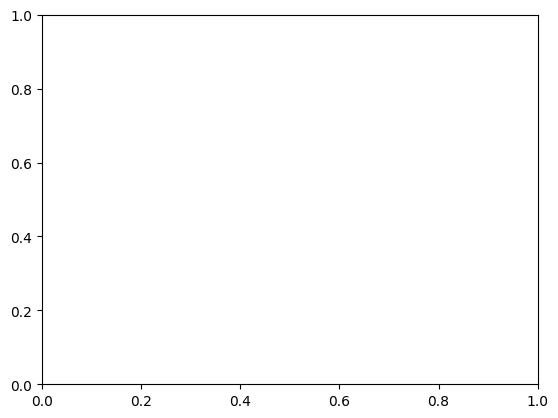

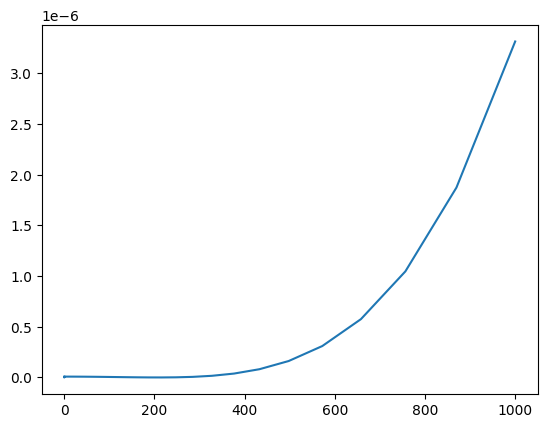

In [47]:
from models import *
fig, ax= plt.subplots()
#profile_plotter(circuit=c1,ax=ax)
#profile_plotter(circuit=cthree,ax=ax)
#plt.show()
print(cthree)
ztwo1=c1.predict(frequencies=f)
zthree1=cthree.predict(frequencies=f)
fig, ax1 = plt.subplots()
models.error_plotter(f,ztwo1,zthree1,ax=ax1)